## 타이타닉 데이터셋 도전

- 승객의 나이, 성별, 승객 등급, 승선 위치 같은 속성을 기반으로 하여 승객의 생존 여부를 예측하는 것이 목표

- [캐글](https://www.kaggle.com)의 [타이타닉 챌린지](https://www.kaggle.com/c/titanic)에서 `train.csv`와 `test.csv`를 다운로드
- 두 파일을 각각 datasets 디렉토리에 titanic_train.csv titanic_test.csv로 저장

### 1. 데이터 적재

In [1]:
import pandas as pd
train_data = pd.read_csv("./titanic_train.csv")
test_data = pd.read_csv("./titanic_test.csv")

### 2. 데이터 탐색

#### train_data 살펴보기

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


* **Survived**: 타깃. 0은 생존하지 못한 것이고 1은 생존을 의미
* **Pclass**: 승객 등급. 1, 2, 3등석.
* **Name**, **Sex**, **Age**: 이름 그대로의 의미
* **SibSp**: 함께 탑승한 형제, 배우자의 수
* **Parch**: 함께 탑승한 자녀, 부모의 수
* **Ticket**: 티켓 아이디
* **Fare**: 티켓 요금 (파운드)
* **Cabin**: 객실 번호
* **Embarked**: 승객이 탑승한 곳. C(Cherbourg), Q(Queenstown), S(Southampton)


#### 누락 데이터 살펴보기

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- **Age**, **Cabin**, **Embarked** 속성의 일부가 null
- 특히 **Cabin**은 77%가 null. 일단 **Cabin**은 무시하고 나머지를 활용
- **Age**는 177개(19%)가 null이므로 이를 어떻게 처리할지 결정해야 함 - null을 중간 나이로 바꾸기 고려
- **Name**과 **Ticket** 속성은 숫자로 변환하는 것이 조금 까다로와서 지금은 무시

#### 통계치 살펴보기

In [5]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* 38%만 **Survived**
* 평균 **Fare**는 32.20 파운드
* 평균 **Age**는 30보다 적음

#### Survived(머신러닝에서 타깃)가 0과 1로 이루어졌는지 확인

In [6]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

#### 범주형(카테고리) 특성들을 확인

In [7]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [8]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [9]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

**Embarked** 특성은 승객이 탑승한 곳 : C=Cherbourg, Q=Queenstown, S=Southampton.

### 3. 전처리 파이프라인

* 특성과 레이블 분리

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import numpy as np

In [11]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
X_train = train_data.drop("Survived", axis=1)
y_train = train_data["Survived"].copy()

In [13]:
X_train.shape

(891, 11)

* 특성을 조합해 또다른 특성(RelativesOnboard)을 만들기(가족과 탑승한 사람과 혼자 탑승한 사람)

In [ ]:
#train_data['RelativesOnboard'] = train_data['SibSp'] + train_data['Parch']+1

In [ ]:
# train_data["AgeBucket"] = train_data["Age"] // 15 * 15
# train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

In [14]:
X_train.values[:, 5].shape

(891,)

* 나만의 변환기(Numpy)

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

col_names = "SibSp", "Parch"
num_attirbs = ['Age', 'SibSp', 'Parch', 'Fare']

# 열 인덱스
SibSp_ix, Parch_ix = [num_attirbs.index(c) for c in col_names]


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self): # *args 또는 **kargs 없음
        pass
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        RelativesOnboard = X[:, SibSp_ix] + X[:, Parch_ix] + 1
        return np.c_[X, RelativesOnboard]




* 범주형 파이프라인 구성

In [5]:
# 1. 누락값을 most_frequent 로 대체
# 2. OneHot Encoding

cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy = "most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse=False) )
])

* 수치형 파이프라인 구성

In [6]:
# 1. 누락값을 median 로 대체

num_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy = "median")),
        ("attribs_adder",CombinedAttributesAdder() )
])

* 범주형 파이프라인 + 수치형 파이프라인

In [7]:
num_attirbs = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Pclass', 'Sex', 'Embarked']

In [8]:
preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attirbs),
        ("cat", cat_pipeline, cat_attribs)
])

In [9]:
X_train_prepared = preprocess_pipeline.fit_transform(X_train)

In [10]:
X_train_prepared.shape

(891, 13)

* 전체 데이터 준비

## 모델 선택, 훈련, 평가(교차검증)

* 분류기 훈련

In [12]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [38]:
# [JGH] 이부분은 필요가 없어요. 이 문제에서는 이미 훈련데이터와 테스트 데이터가 파일로 나뉘어져있거든요.
X_tr, X_ts, y_tr, y_ts = train_test_split(X_train_prepared, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [ ]:
# [JGH] 먼저 여러 모델 성능을 비교해 보면 좋기 때문에 교차 검증을 사용하겠습니다.

In [ ]:
##################################################################################

* SVC

In [13]:
svm_clf = SVC(gamma="auto", random_state=42)
cross_val_score(svm_clf, X_train_prepared, y_train, cv=3, scoring="accuracy")

array([0.68686869, 0.69360269, 0.73737374])

In [ ]:
# cross_val_score는 정확도에 대한 점수를 구한것이고
# cross_val_predict는 실제 예측값을 뽑아내주죠

In [14]:
y_predic_svm = cross_val_predict(svm_clf, X_train_prepared, y_train, cv=3)

In [ ]:
# y_predic_svm를 갖고 재현율/정밀도 등도 같이 확인할 수 있습니다.

In [15]:
precision_score(y_train, y_predic_svm)

0.6351351351351351

In [16]:
recall_score(y_train, y_predic_svm)

0.5497076023391813

In [ ]:
# 위와 동일한 방법으로 다른 모델들도 검증해 볼게요!

* kNN

In [17]:
knn_clf = KNeighborsClassifier(n_neighbors=1)  
cross_val_score(knn_clf, X_train_prepared, y_train, cv=3, scoring="accuracy")

array([0.6969697 , 0.69360269, 0.67003367])

In [18]:
y_predic_knn = cross_val_predict(knn_clf, X_train_prepared, y_train, cv=3)

In [19]:
precision_score(y_train, y_predic_knn)

0.5934718100890207

In [20]:
recall_score(y_train, y_predic_knn)

0.5847953216374269

* SGD

In [21]:
sgd_clf = SGDClassifier(random_state=42)
cross_val_score(sgd_clf, X_train_prepared, y_train, cv=3, scoring="accuracy")

array([0.78451178, 0.77441077, 0.72053872])

In [22]:
y_predic_sgd = cross_val_predict(sgd_clf, X_train_prepared, y_train, cv=3)

In [23]:
precision_score(y_train, y_predic_sgd)

0.6702127659574468

In [24]:
recall_score(y_train, y_predic_sgd)

0.7368421052631579

In [ ]:
# 점수가 좋은것들은 f1 score, auc score도 확인해 봤습니다.

In [25]:
f1_score(y_train, y_predic_sgd)

0.701949860724234

In [26]:
y_scores_sgd = cross_val_predict(sgd_clf, X_train_prepared, y_train, cv=3, method="decision_function")

In [27]:
roc_auc_score(y_train, y_scores_sgd)

0.7915188700348321

* RandomForest

In [28]:
forest_clf = RandomForestClassifier(random_state=42)
cross_val_score(forest_clf, X_train_prepared, y_train, cv=3, scoring="accuracy")

array([0.77441077, 0.81818182, 0.78451178])

In [29]:
y_predic_forest = cross_val_predict(forest_clf, X_train_prepared, y_train, cv=3)

In [30]:
precision_score(y_train, y_predic_forest)

0.7371601208459214

In [31]:
recall_score(y_train, y_predic_forest)

0.7134502923976608

In [32]:
f1_score(y_train, y_predic_forest)

0.725111441307578

In [33]:
y_scores_forest = cross_val_predict(forest_clf, X_train_prepared, y_train, cv=3, method="predict_proba")

In [45]:
roc_auc_score(y_train, y_scores_forest[:, 1])

0.8396286709487745

In [ ]:
# 몇몇 후보 모델중 RandomForest 모델이 점수가 높아서 이 모델로 튜닝을 하겠습니다.

In [49]:
param_grid = [
    {'n_estimators' : [100, 200], 'max_features' : [2, 4, 6, 8, 10]},
]

In [50]:
grid_search = GridSearchCV(forest_clf, param_grid, scoring='accuracy', cv=5,  n_jobs = -1)

In [51]:
grid_search.fit(X_train_prepared, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid=[{'max_features': [2, 4, 6, 8, 10],
                          'n_estimators': [100, 200]}],
             scoring='accuracy')

In [52]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 100}

In [53]:
grid_search.best_score_

0.8159688657334756

In [54]:
final_model = grid_search.best_estimator_

* 최종 성능 평가

In [ ]:
# 훈련세트에서 전처리 한것을 테스트세트에서도 동일하게 적용합니다.

In [55]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = final_model.predict(X_test)

In [56]:
# 최종 예측을 경진대회에 sumbit 합니다.

In [58]:
submission = pd.read_csv("./gender_submission.csv")
submission

submission["Survived"] = y_pred

print(submission.shape)
submission.head()

(418, 2)


,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,1
4,896,1


In [57]:
ver = 1

submission.to_csv("datasets/ver_{0}_submission.csv".format(ver), index=False)

(418, 2)


In [ ]:
##################################################################################

In [39]:
svm_clf = SVC(gamma="auto" ,random_state=42)
svm_clf.fit(X_tr, y_tr)

SVC(gamma='auto', random_state=42)

In [40]:
some_digit = X_train_prepared[0]
svm_clf.predict([some_digit])

array([0], dtype=int64)

In [41]:
some_digit_scores = svm_clf.decision_function([some_digit])

In [42]:
np.argmax(some_digit_scores)

0

In [44]:
svm_clf.classes_

array([0, 1], dtype=int64)

* kNN

In [69]:
knn = KNeighborsClassifier(n_neighbors=1) 

In [70]:
knn.fit(X_tr, y_tr)

KNeighborsClassifier(n_neighbors=1)

In [71]:
knn.score(X_ts, y_ts)

0.7374301675977654

* SGD

In [45]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_tr, y_tr)

SGDClassifier(random_state=42)

In [47]:
y_tr_pred = cross_val_predict(sgd_clf, X_tr, y_tr, cv=3)

In [72]:
cross_val_score(sgd_clf, X_tr, y_tr, cv=3, scoring="accuracy")

array([0.76890756, 0.69198312, 0.64978903])

* RandomForest

In [58]:
forest_clf = RandomForestClassifier(random_state=42)

In [60]:
y_scores_forest = cross_val_predict(forest_clf, X_tr, y_tr, cv=3, method="predict_proba")

In [61]:
y_scores_forest.shape

(712, 2)

In [62]:
y_scores_forest = y_scores_forest[:, 1]

In [63]:
y_scores_forest.shape

(712,)

In [68]:
cross_val_score(forest_clf, X_tr, y_tr, cv=3, scoring="accuracy")

array([0.78991597, 0.80168776, 0.81012658])

* 분류기 평가

In [ ]:
* 정확도 / 정밀도 / 재현율 / F1 Score/ ROC 

In [ ]:
# 정확도

In [52]:
cross_val_score(sgd_clf, X_tr, y_tr, cv=3, scoring="accuracy")

array([0.76890756, 0.69198312, 0.64978903])

In [ ]:
# 정밀도

In [48]:
precision_score(y_tr, y_tr_pred)

0.62109375

In [ ]:
# 재현율

In [49]:
recall_score(y_tr, y_tr_pred)

0.5824175824175825

In [ ]:
# F1 Score

In [50]:
f1_score(y_tr, y_tr_pred)

0.6011342155009451

In [ ]:
# ROC 곡선

In [ ]:
# SGD 사용

In [53]:
y_scores = cross_val_predict(sgd_clf, X_tr, y_tr, cv=3, method="decision_function")

In [55]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_tr, y_scores)

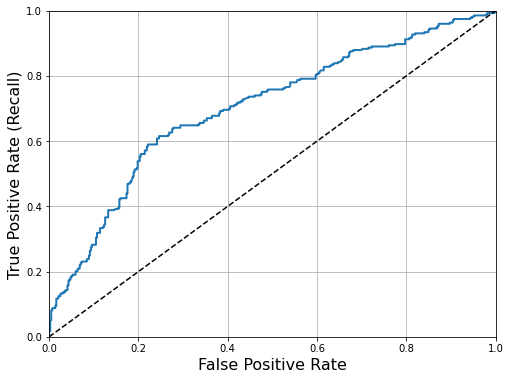

In [56]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.show()

In [57]:
roc_auc_score(y_tr, y_scores)

0.7017488965097166

In [ ]:
# randomforest 사용

In [64]:
fpr, tpr, thresholds = roc_curve(y_tr, y_scores_forest)

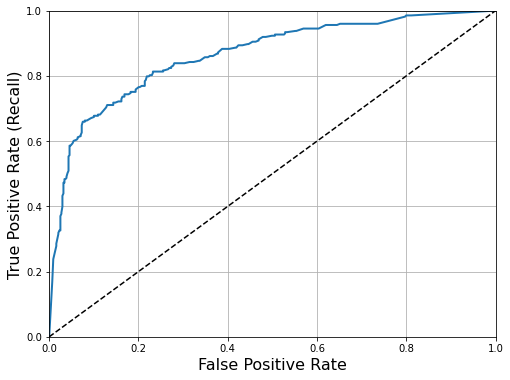

In [65]:
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.show()

* 파라미터 튜닝

In [73]:
param_grid = [{'n_estimators': [50, 100, 200]}]

In [74]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_tr, y_tr)
grid_search = GridSearchCV(forest_reg, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs = -1)

In [75]:
grid_search.fit(X_tr, y_tr)

UnicodeEncodeError: 'ascii' codec can't encode characters in position 18-20: ordinal not in range(128)

In [ ]:
grid_search.best_params_

In [ ]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

* 최종 성능 평가

In [ ]:
final_model = grid_search.best_estimator_

In [ ]:
final_predictions = final_model.predict(X_test)

In [ ]:
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

In [ ]:
final_model.score(X_test, y_test)

* 제출용 CSV 만들기

In [ ]:
submission = pd.read_csv("./gender_submission.csv")
submission

submission["Survived"] = y_scores_forest # 여기 y_pred에 y_scores_forest 이것을 넣는 것이 맞는것일까?????

print(submission.shape)
submission.head()

ver = 1 

submission.to_csv("datasets/ver_{0}_submission.csv".format(ver), index=False)